## Linear and Logistic Regression

분류 예측을 하는데 주로 쓰임

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint
%matplotlib inline

print(tf.__version__)

/Users/Yeoni/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.0-dev20190102


### 1) Linear Regression with huber loss by high-level

In [2]:
data = pd.read_table('../examples/data/birth_life_2010.txt')
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


나라별 출생, 출산률, 기대수명

In [3]:
x = data.loc[:,'Birth rate'].values
y = data.loc[:,'Life expectancy'].values
print(x.shape, y.shape)

(190,) (190,)


[참고][데이터 사이언스 스쿨]("https://datascienceschool.net/view-notebook/8bf41f87a08b4c44b307799577736a28/")

이미 있는 데이터 집합에서 일부를 무작위로 선택하는 것을 샘플링(sampling)이라고 한다. 샘플링에는 choice 명령을 사용한다. choice 명령은 다음과 같은 인수를 가질 수 있다.

`numpy.random.choice(a, size=None, replace=True, p=None)`

`a : 배열이면 원래의 데이터, 정수이면 arange(a) 명령으로 데이터 생성
size : 정수. 샘플 숫자
replace : 불리언. True이면 한번 선택한 데이터를 다시 선택 가능
p : 배열. 각 데이터가 선택될 수 있는 확률`

In [5]:
# split train and validation
# 전체의 70%만 가지고 와서 트레이닝 셋을 만들고자 함

tr_indices = np.random.choice(range(x.shape[0]), size = int(x.shape[0] * .7), replace=False)

x_tr = x[tr_indices]
y_tr = y[tr_indices]

x_val = np.delete(x, tr_indices, axis = 0)
y_val = np.delete(y, tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(133,) (133,)
(57,) (57,)


## Graph for linear regression

In [ ]:
tf.reset_default_graph() 

value : 상수의 값이다.

dtype : 상수의 데이타형이다. tf.float32와 같이 실수,정수등의 데이타 타입을 정의한다.

shape : 행렬의 차원을 정의한다. shape=[3,3]으로 정의해주면, 이 상수는 3x3 행렬을 저장하게 된다.

name : name은 이 상수의 이름을 정의한다. name에 대해서는 나중에 좀 더 자세하게 설명하도록 하겠다.



출처: http://bcho.tistory.com/1150 [조대협의 블로그]

In [9]:
# create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype = tf.float32, shape = [None])
Y = tf.placeholder(dtype = tf.float32, shape = [None])

# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weight', initializer = tf.constant(.0))
b = tf.get_variable(name = 'bias', initializer = tf.constant(.0))

# construct model to predict Y
yhat = X * w + b

# use the square error as huber loss function

huber_loss = tf.losses.huber_loss(labels = Y, predictions = yhat, delta = 14.)
huber_loss_summ = tf.summary.scalar(name = 'huber_loss', tensor = huber_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(huber_loss)

Instructions for updating:
Colocations handled automatically by placer.


### huber loss 

loss function의 일종으로 강건한 타입.

정방향에서는 델타의 범위가 -1 ~ 1 을 벗어날 경우 델타의 절대값에서 0.5 를 빼게 됩니다. 역방향 계산에서는 L1 손실의 도함수처럼 x 의 부호에 따라 1 또는 -1 이 됩니다.
[참고 : 텐서플로우 블로그]


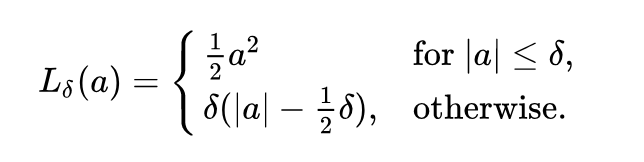

[그림출처:위키피디아]

## training

- batch_size => 한 번에 처리하는 데이터 수
- max_iter =>반복을 몇 번 할지. 
  - batch가 100이고 mat_iter가 60000이면 총 6백만개로 학습
- epoch => 전체 데이터를 딱 한번 사용했을때. 학습용 전체 데이터가 5만개라고 했을 때 위의 경우에는 6.000,000/50,000 = 120 epoch라고 얘기함

[참고 블로그][클릭]("http://crmn.tistory.com/8")

In [11]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0]/batch_size)
print(total_step)

23


In [12]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_high_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_high_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [13]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                         size = batch_size, replace = False)
        
        val_indices = np.random.choice(range(x_val.shape[0]),
                                       size = batch_size, replace = False)
        
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, huber_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        
        tr_loss_summ = sess.run(huber_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [huber_loss, huber_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 695.62, val_loss : 669.19
epoch :  10, tr_loss : 310.42, val_loss : 305.51
epoch :  20, tr_loss : 258.60, val_loss : 221.39
epoch :  30, tr_loss : 180.23, val_loss : 186.37
epoch :  40, tr_loss : 116.20, val_loss : 122.45
epoch :  50, tr_loss : 72.51, val_loss : 76.18
epoch :  60, tr_loss : 43.62, val_loss : 45.03
epoch :  70, tr_loss : 23.81, val_loss : 26.89
epoch :  80, tr_loss : 16.60, val_loss : 21.86
epoch :  90, tr_loss : 15.21, val_loss : 16.43


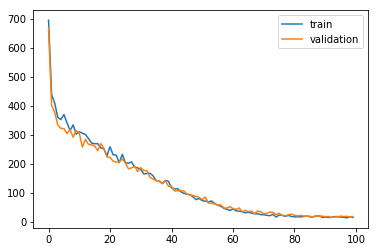

In [14]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

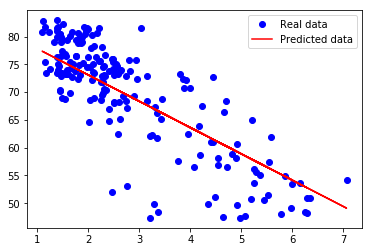

In [15]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()

### 2) Linear Regression with huber loss by low-level

In [16]:
tf.reset_default_graph() 

### Define the graph of Simple Linear Regression


In [17]:
# create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype = tf.float32, shape = [None])
Y = tf.placeholder(dtype = tf.float32, shape = [None])

# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weight', initializer = tf.constant(.0))
b = tf.get_variable(name = 'bias', initializer = tf.constant(.0))

# construct model to predict Y
yhat = X * w + b

# use the square error as huber loss function
# 잔차를 새로 만들고 조건을 달아 새로 만듬
residual = tf.abs(Y - yhat)
huber_loss = tf.cond(tf.reduce_mean(residual) <= 14.,
                     lambda : .5 * tf.reduce_mean(tf.square(residual)),
                     lambda : 14. * tf.reduce_mean(residual) - .5 * tf.square(14.))

huber_loss_summ = tf.summary.scalar(name = 'huber_loss', tensor = huber_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(huber_loss)

### Training

In [18]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_low_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_huber_low_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [19]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                         size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                       size = batch_size, replace = False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, huber_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        tr_loss_summ = sess.run(huber_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [huber_loss, huber_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

epoch :   0, tr_loss : 712.77, val_loss : 659.53
epoch :  10, tr_loss : 245.69, val_loss : 311.01
epoch :  20, tr_loss : 220.24, val_loss : 230.11
epoch :  30, tr_loss : 160.67, val_loss : 174.33
epoch :  40, tr_loss : 113.92, val_loss : 104.48
epoch :  50, tr_loss : 66.23, val_loss : 66.31
epoch :  60, tr_loss : 33.25, val_loss : 41.79
epoch :  70, tr_loss : 19.17, val_loss : 30.34
epoch :  80, tr_loss : 16.11, val_loss : 22.20
epoch :  90, tr_loss : 17.44, val_loss : 16.69


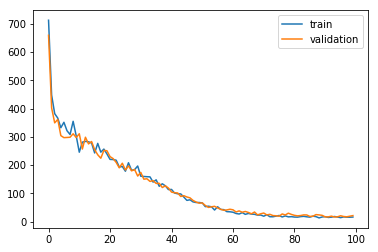

In [20]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

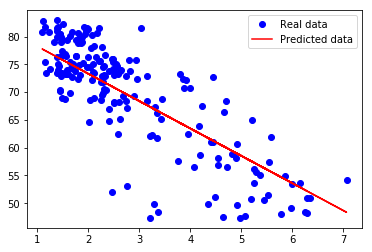

In [21]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()

### 3) Linear Regression with mse loss


In [22]:
tf.reset_default_graph()

In [23]:
# create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype = tf.float32, shape = [None])
Y = tf.placeholder(dtype = tf.float32, shape = [None])

# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weight', initializer = tf.constant(.0))
b = tf.get_variable(name = 'bias', initializer = tf.constant(.0))

# construct model to predict Y
yhat = X * w + b

# use the square error as loss function
mse_loss = tf.reduce_mean(tf.square(Y - yhat))
mse_loss_summ = tf.summary.scalar(name = 'mse_loss', tensor = mse_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(mse_loss)

In [24]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0] / batch_size)
print(total_step)

23


In [25]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_mse_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/linreg_mse_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [ ]:

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                         size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                       size = batch_size, replace = False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, mse_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        tr_loss_summ = sess.run(mse_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [mse_loss, mse_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 1652.02, val_loss : 1433.98
epoch :  10, tr_loss : 257.30, val_loss : 228.88
epoch :  20, tr_loss : 63.57, val_loss : 70.88
epoch :  30, tr_loss : 33.84, val_loss : 43.04
epoch :  40, tr_loss : 33.93, val_loss : 39.88
epoch :  50, tr_loss : 30.74, val_loss : 31.99


In [ ]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [ ]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()

### 4) Logistic Regression with ce loss

CE loss : Cross-entropy loss

이터의 분포 P(x)와 모델이 추정한 데이터의 분포 Q(x) 간에 차이를 최소화

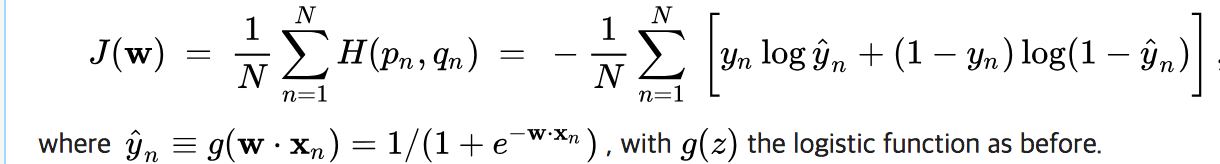

[그림출처:위키피디아]

### Load and Pre-process data

In [ ]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 784)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 784)

In [ ]:
tf.reset_default_graph() 

In [ ]:
tr_indices = np.random.choice(range(x_train.shape[0]), 
                             size = 55000,
                             replace = False)
x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices,axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices,axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

### Define the graph of Softmax Classifier


In [ ]:
# create placeholders for X (birth rate) and Y (life expectancy)

X = tf.placeholder(dtype = tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype = tf.int32, shape = [None])

# weight, bias

w = tf.get_variable(name = 'weights', shape = [784, 10], dtype = tf.float32,
                   initializer = tf.contrib.layers.xavier_initializer()) 

b = tf.get_variable(name = 'bias', shape = [10], dtype = tf.float32,
                   initializer = tf.zeros_initializer())

score = tf.matmul(X, w)+b

ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = Y, logits=score))
ce_loss_summ = tf.summary.scalar(name = 'ce_loss', tensor = ce_loss)

opt = tf.train.GradientDescentOptimizer(learning_rate = .01)
training_op = opt.minimize(ce_loss)

### training

In [ ]:
epochs = 30
batch_size = 64
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

In [ ]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_placeholder/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_placeholder/val',
                                     graph = tf.get_default_graph())

In [ ]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth = True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avr_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]), size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]), size = batch_size, replace = False)
        
        batch_xs = x_tr[batch_indices] 
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches = [training_op, ce_loss],
                              feed_dict = {X : batch_xs, Y : batch_ys})
        tr_loss_summ = sess.run(ce_loss_summ, feed_dict = {X : batch_xs, Y : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [ce_loss, ce_loss_summ],
                                           feed_dict = {X : val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)
    
    if epoch % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

In [ ]:
lt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()